# Background blurring in portrait mode

1. Define input image and the mask

In [1]:
from PIL import Image

input_path = '../inputs/background-blurring/motorcycle.png'
input_image = Image.open(input_path)

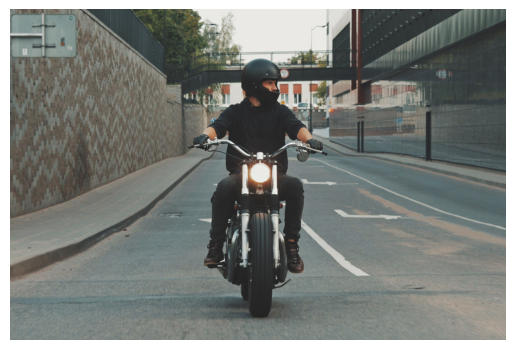

In [2]:
from matplotlib import pyplot as plt

plt.imshow(input_image)
plt.axis('off')
plt.show()

Set the blur and sharpen parameters

In [3]:
blur = 15
sharpen = 0

In [7]:
import os, sys

input_image = input_image.convert("RGB")
blur = int(blur)
sharpen = int(sharpen)

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(os.path.dirname(current_dir), '..'))
sys.path.append(os.path.join(parent_dir, 'code'))

Load the RMBG-1.4 model for foreground extraction

In [11]:
from transformers import AutoModelForImageSegmentation
import torch

model = AutoModelForImageSegmentation.from_pretrained("briaai/RMBG-1.4",trust_remote_code=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

BriaRMBG(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool_in): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (stage1): RSU7(
    (rebnconvin): REBNCONV(
      (conv_s1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (rebnconv1): REBNCONV(
      (conv_s1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv2): REBNCONV(
      (conv_s1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReL

Extract the foreground image

In [12]:
from extract_foreground import preprocess_image, postprocess_image
from scipy.ndimage import label, find_objects
import numpy as np

# set the values for model size and images of how much percent of whole image should be dismissed
model_size = (1024, 1024)
img_percent = 0.05

if img_percent < 0.0 or img_percent > 1.0:
    raise ValueError('The img_percent variable should be in the range (0.0, 1.0)')

dismissed_pixels = img_percent * model_size[0] * model_size[1]

# prepare input
input_image_size = np.array(input_image).shape[:2]
input_image = input_image.resize(model_size)

orig_im = np.array(input_image)
orig_im_size = orig_im.shape[0:2]
model_input_size = model_size
image = preprocess_image(orig_im, model_input_size).to(device)

# inference 
result = model(image)

# post process
result_image = postprocess_image(result[0][0], orig_im_size)

# save result
pil_im = Image.fromarray(result_image)
no_bg_image = Image.new("RGBA", pil_im.size, (0,0,0,0))

# remove small groups of foreground map
np_im = np.array(pil_im)
np_im[np_im > 0] = 1
labeled_array, num_features = label(np_im)
objects = find_objects(labeled_array)
for i, obj_slice in enumerate(objects):
    if np.sum(labeled_array[obj_slice] == (i + 1)) < dismissed_pixels:      # The whole image has 1024x1024 ~ 10^6 pixels
        np_im[labeled_array == (i + 1)] = 0
masked_im = np_im * np.array(pil_im)
cleaned_pil_im = Image.fromarray(masked_im)

# apply the mask
no_bg_image.paste(input_image, mask=cleaned_pil_im)
no_bg_image = no_bg_image.resize((input_image_size[1], input_image_size[0]))

foreground_image = no_bg_image

OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 

Visualise the foreground element

In [ ]:
plt.imshow(foreground_img)
plt.axis('off')
plt.show()

Apply blur to the image

In [15]:
from PIL import Image, ImageFilter
from blur_image import transform
import cv2

image = np.array(input_image)
image_norm = np.array(image) / 255.0
image_norm = transform({'image': image_norm})['image']
image_norm = torch.from_numpy(image_norm).unsqueeze(0)

# resize the orignal image to the normalized
np_image = np.array(image_norm).squeeze(0).transpose(1, 2, 0).astype(np.uint8)
resized_image = cv2.resize(image, (np_image.shape[1], np_image.shape[0]))

# run depth anything
with torch.no_grad():
    output = model(image_norm)

# visualize the prediction
output = output.squeeze().cpu().numpy()
prediction = (output * 255 / np.max(output)).astype("uint8")

# blur image given depth map
oimg = Image.fromarray(resized_image)
mimg = Image.fromarray(prediction)

bimg = oimg.filter(ImageFilter.BoxBlur(int(boxBlur)))
bimg = bimg.filter(ImageFilter.BLUR)
for _ in range(sharpen):
    bimg = bimg.filter(ImageFilter.SHARPEN)

rimg = Image.composite(oimg, bimg, mimg)
blurred_image = rimg.resize((image.shape[1], image.shape[0]))


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
plt.imshow(blurred_image)
plt.axis('off')
plt.show()

Paste the original foreground on top of the blurred image to increase the quality

In [4]:
blurred_image.paste(foreground_image, foreground_image)

input points: [[[200, 300], [480, 290]]]


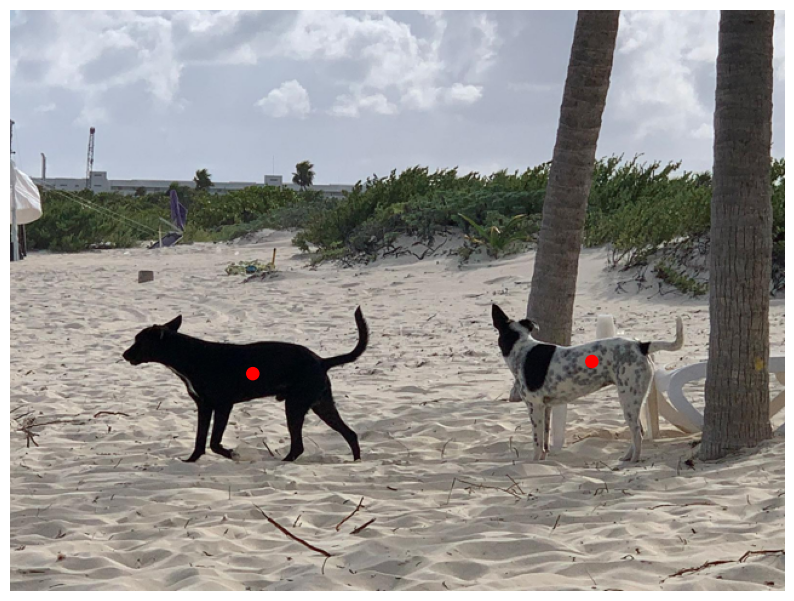

In [5]:
plt.imshow(blurred_image)
plt.axis('off')
plt.show()

Final results

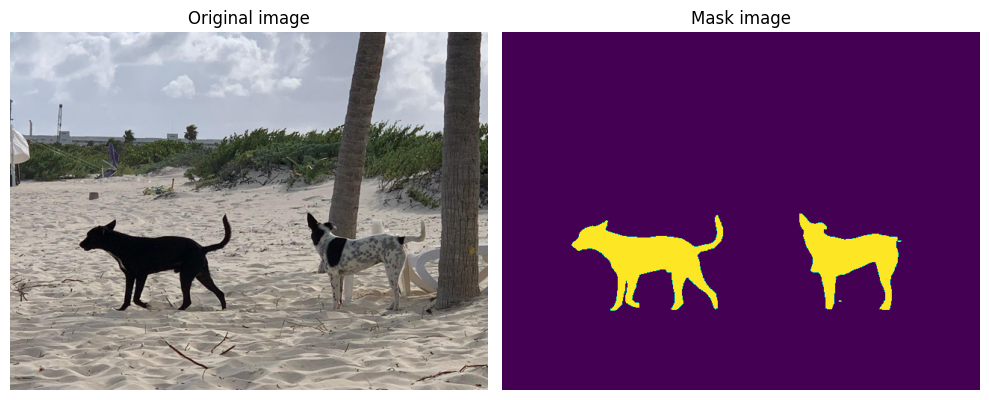

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(input_image)
axs[0].axis('off')  # Hide the axis
axs[0].set_title('Original image')  # Optionally set a title

# Display the second image in the right subplot
axs[1].imshow(blurred_image)
axs[1].axis('off')  # Hide the axis
axs[1].set_title('Mask image')  # Optionally set a title

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()